<a href="https://colab.research.google.com/github/Callmewuxin/fish_classification/blob/master/object_detection_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
ls

gdrive/  sample_data/


In [0]:
cd gdrive/My Drive/app/models/research/object_detection

/content/gdrive/My Drive/app/models/research/object_detection


# Imports

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Env setup

In [0]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [0]:
from utils import label_map_util

from utils import visualization_utils as vis_util
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.p

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [0]:
# What model to download.
MODEL_NAME = 'fish_models'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'fish_label_map.pbtxt')

## Download Model

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

IOError: ignored

## Load a (frozen) Tensorflow model into memory.

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

W0713 02:32:30.424494 140545397823360 deprecation_wrapper.py:119] From utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



## Helper code

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  arr = np.array(image.getdata())
  return arr.reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Retain box which score greater than thresh

In [0]:
def retain_boxes(boexes, scores, min_score_thresh):
  retainboxes = []
  retainscores = []
  boexes = boxes.tolist()
  scores = scores.tolist()
  for i, box in enumerate(boxes):
    if scores[i]>min_score_thresh:
      retainboxes.append(box)
      retainscores.append(scores[i])
      ymin, xmin, ymax, xmax = box
      if ymin==0:
        break
  return retainboxes, retainscores
      

# draw bouding box (object detection)

In [0]:
def draw_boudingbox(image, boxes,scores, line_thickness,index,color):
  im_width, im_height = image.size
  draw = ImageDraw.Draw(image)
  font = ImageFont.truetype('Roboto-Bold.ttf', size=10)
  for i, box in enumerate(boxes):
    ymin, xmin, ymax, xmax = box
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    t_color = 'rgb(255, 255, 255)'
    m = index[i%3]
    scores[i]= round(scores[i]*100, 2)
    m =  m + ': ' + str(scores[i]) + '%' 
    c = color[i%3]
    display_str_heights = [font.getsize(ds)[1] for ds in index]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    text_width, text_height = font.getsize(m)
    margin = np.ceil(0.05 * text_height)
    if top > total_display_str_height:
      text_bottom = top
    else:
      text_bottom = bottom + total_display_str_height
    text_color = 'rgb(255, 255, 255)' # black color

    draw.line([(left, top), (left, bottom), (right, bottom),
           (right, top), (left, top)], width=line_thickness, fill=c)
    draw.text((left + margin, text_bottom - text_height - margin), m, fill=text_color, font=font)
  return image
  

# Detection

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.png'.format(i)) for i in range(5, 6) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})
      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

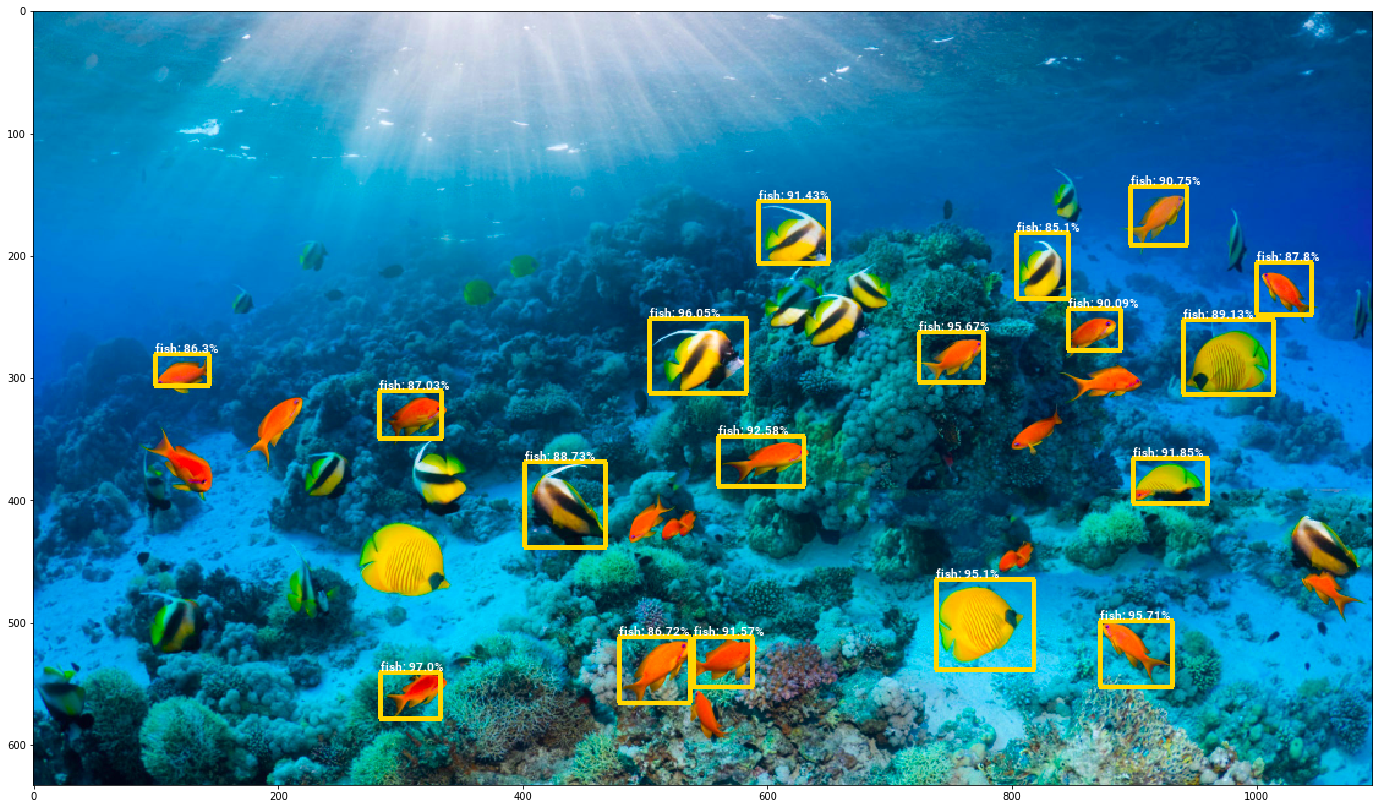

In [0]:
# define min_score_thresh
min_score_thresh = 0.85
color = ['rgb(255,215,0)','rgb(255,215,0)', 'rgb(255,215,0)']
index = ["fish","fish", "fish"]
#olor = ['DarkViolet', 'DeepPink','LawnGreen']
for i in TEST_IMAGE_PATHS:
  image = Image.open(i)
  image = image.convert('RGB')
  im_width, im_height = image.size
  # initialise the drawing context with
  # the image object as background
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  image_pil = Image.fromarray(np.uint8(image_np)).convert('RGB')
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  boxes = output_dict['detection_boxes']
  scores = output_dict['detection_scores']
  retainboxes, retainscores = retain_boxes(boxes, scores, min_score_thresh)
  draw_boudingbox(image, retainboxes,retainscores, 4,index,color)
  plt.figure(figsize=(24,16))
  plt.imshow(image)

#delete file in crop_img

In [0]:
import os
path = 'crop_img/predict'
for file in os.listdir(path):
  path_file = os.path.join(path, file)
  if os.path.isfile(path_file):
    os.remove(path_file)

#cut the origin image by bounding box

In [0]:
name2boudingbox = {}
for i, box in enumerate(retainboxes):
  ymin, xmin, ymax, xmax = box
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  st1 = int(left)
  st2 = int(top)
  right = int(right)
  bottom = int(bottom)
  cropimg = image_pil.crop((st1, st2, right, bottom))
  path = 'crop_img/predict/'
  name = 'img' + str(i+1) + '.jpg'
  file_name = 'predict/' + name
  name2boudingbox[file_name] = box.tolist()
  file_path = path+name
  plt.figure(figsize=(2,2))
  cropimg.save(file_path)
  plt.imshow(cropimg)

#fish classfication using CNN_SENet

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import tensorflow as tf
import os
import pandas as pd


model_dir = 'fish_classification_model/res.h5'
if os.path.exists(model_dir):
  print('yes')
else:
  print('no')

labels = {"Cooper anthias" :0,"Schooling Banner":1, "Masked Butterfly":2}
color = ['rgb(255,215,0)','rgb(255,106,106)', 'rgb(255,165,0)']
labels = dict((v,k) for k,v in labels.items())
test_dir = 'crop_img'
model = load_model(model_dir)
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=18,
    class_mode='categorical',
    shuffle=False
)
test_generator.reset()
pred = model.predict_generator(test_generator, steps=1)
print(pred)
predicted_class_indices = np.argmax(pred, axis=1)
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
name2predictions = {}
for i, name in enumerate(filenames):
  name2predictions[name] = predictions[i]
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)

Using TensorFlow backend.
W0712 06:31:32.716156 140558265423744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 06:31:32.734366 140558265423744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0712 06:31:32.764760 140558265423744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 06:31:32.766314 140558265423744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0712

yes


W0712 06:31:33.046333 140558265423744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0712 06:31:34.079015 140558265423744 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0712 06:31:34.866754 140558265423744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0712 06:31:35.008388 140558265423744 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorf

Found 18 images belonging to 1 classes.
[[8.98638904e-01 9.29535180e-02 8.40757508e-03]
 [8.68222892e-01 1.18907265e-01 1.28698852e-02]
 [9.16028023e-01 6.38346076e-02 2.01373529e-02]
 [5.96151548e-03 9.82194841e-01 1.18436441e-02]
 [2.57359557e-02 1.29589504e-02 9.61305141e-01]
 [9.71936584e-01 1.35941450e-02 1.44692082e-02]
 [8.92345846e-01 9.11039859e-02 1.65501721e-02]
 [8.79144251e-01 1.15472421e-01 5.38335647e-03]
 [9.12580013e-01 6.82637691e-02 1.91562921e-02]
 [6.09002681e-03 2.19308361e-02 9.71979201e-01]
 [5.43267466e-04 2.70039961e-03 9.96756375e-01]
 [9.44679320e-01 3.97630967e-02 1.55576337e-02]
 [8.73851836e-01 8.95759314e-02 3.65722477e-02]
 [2.24698940e-03 9.94291067e-01 3.46203987e-03]
 [8.72483134e-01 1.03512198e-01 2.40046382e-02]
 [2.85896356e-04 9.99691486e-01 2.26852699e-05]
 [9.27384794e-01 6.03641793e-02 1.22509850e-02]
 [4.11811797e-03 7.01345876e-02 9.25747275e-01]]
             Filename       Predictions
0    predict/img1.jpg    Cooper anthias
1   predict/img

# draw boudingbox and label (fish classification)

In [0]:
def draw_boudingbox_label(image, boxes,scores, line_thickness,index,color):
  im_width, im_height = image.size
  draw = ImageDraw.Draw(image)
  font = ImageFont.truetype('Roboto-Bold.ttf', size=10)
  for i, box in enumerate(boxes):
    ymin, xmin, ymax, xmax = box
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    t_color = 'rgb(255, 255, 255)'
    name = 'predict/img' + str(i+1) + '.jpg'
    box = name2boudingbox[name]
    prediction = name2predictions[name]
    c = color[prediction]
    ymin, xmin, ymax, xmax = box
    display_str_heights = [font.getsize(ds)[1] for ds in index]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    text_width, text_height = font.getsize(prediction)
    margin = np.ceil(0.05 * text_height)
    if top > total_display_str_height:
      text_bottom = top
    else:
      text_bottom = bottom + total_display_str_height
    text_color = 'rgb(255, 255, 255)' # black color

    draw.line([(left, top), (left, bottom), (right, bottom),
           (right, top), (left, top)], width=line_thickness, fill=c)
    draw.text((left + margin, text_bottom - text_height - margin), prediction, fill=text_color, font=font)
  return image
  

#draw label on image

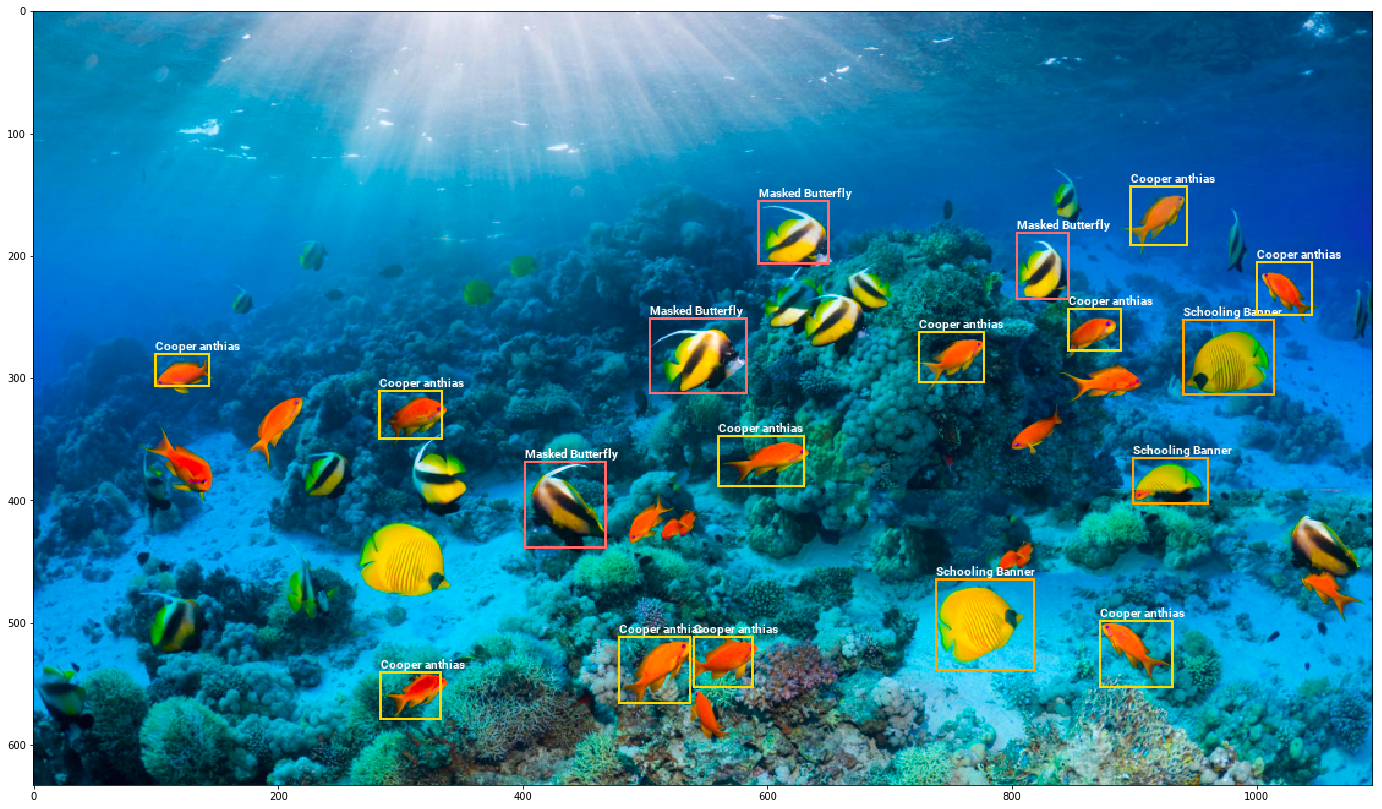

In [0]:
index = ["Cooperanthias","SchoolingBanner", "MaskedButterfly"]
color = {'Cooper anthias': 'rgb(255,215,0)','Masked Butterfly':'rgb(255,106,106)','Schooling Banner':'rgb(255,165,0)'}
draw_boudingbox_label(image_pil, retainboxes,retainscores, 2,index,color)
plt.figure(figsize=(24,16))
plt.imshow(image_pil)


#object detection in video

## delete all files in video_frame

In [0]:
import os
path = 'video_frame'
for file in os.listdir(path):
  path_file = os.path.join(path, file)
  if os.path.isfile(path_file):
    os.remove(path_file)

## save vidoe frame  by sec

In [0]:
import cv2
vidcap = cv2.VideoCapture('test_images/fish.mp4')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("video_frame/image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames
sec = 0
frameRate = 0.05 #//it will capture image in each 0.1 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

## draw bouding box and convert image to video

In [0]:
cd ..

/content/gdrive/My Drive/app/models/research/object_detection


In [0]:
import cv2
import numpy as np
import os
from os.path import isfile, join
pathIn= 'video_frame/'
pathOut = 'test_images/output.avi'
fps = 10
frame_array = []
size = (1280, 720)
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
color = ['rgb(255,215,0)','rgb(255,215,0)', 'rgb(255,215,0)']
index = ["fish","fish", "fish"]

for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename) # cv type image
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    image = Image.fromarray(img)   # convert to pil image
    print(image.size)
    '''
    image_np = load_image_into_numpy_array(image) # convert image to array
    image_np = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np, detection_graph)  
    boxes = output_dict['detection_boxes']
    scores = output_dict['detection_scores']
    retainboxes, retainscores = retain_boxes(boxes, scores, 0.85)
    draw_boudingbox(image, retainboxes,retainscores,2,index,color)
    image_np = load_image_into_numpy_array(image)
    output_rgb = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    #inserting the frames into an image array
    frame_array.append(output_rgb)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()
print('end')
'''

In [0]:
import cv2
import numpy as np
import os
from os.path import isfile, join
color = ['rgb(255,215,0)','rgb(255,215,0)', 'rgb(255,215,0)']
index = ["fish","fish", "fish"]
pathIn = 'video_frame/'
# 输出视频路径
video_dir = 'test_images/output4test2.avi'
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
# 帧率
fps = 20
# 图片数
# 图片尺寸
img_size = (1920, 1080)
fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
video_writer = cv2.VideoWriter(video_dir, fourcc, fps, img_size)
for i in range(len(files)):
    print(i)
    filename = pathIn + files[i+1]
    frame = cv2.imread(filename)
    img = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    image = Image.fromarray(img)   # convert to pil image
    image_np = load_image_into_numpy_array(image)
    image_np = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np, detection_graph)  
    boxes = output_dict['detection_boxes']
    scores = output_dict['detection_scores']
    retainboxes, retainscores = retain_boxes(boxes, scores, 0.5)
    draw_boudingbox(image, retainboxes,retainscores,2,index,color)
    image_np = load_image_into_numpy_array(image)
    output_rgb = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    #inserting the frames into an image array
    video_writer.write(output_rgb)
video_writer.release()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
